# Test PyLIMA v1.9 

In [1]:
from pyLIMA import event
from pyLIMA import telescopes
import numpy as np
import matplotlib.pyplot as plt
import pygtc

In [2]:
from pyLIMA.fits import LM_fit
from pyLIMA.fits import DE_fit
from pyLIMA.fits import MCMC_fit
from pyLIMA.fits import TRF_fit
from pyLIMA.fits import fit_metrics
from pyLIMA.fits import stats
from pyLIMA.models import PSPL_model
from pyLIMA.models import FSPL_model
from pyLIMA.models import PSBL_model
from scipy.signal import savgol_filter
from pyLIMA.models import USBL_model
import warnings 
warnings.simplefilter('ignore', np.RankWarning)
from pyLIMA.models import DSPL_model
from astropy.coordinates import SkyCoord
from astropy import units as u
#in v2 we need to separately call plots.
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA import toolbox
#Some of our techniques are heuristic and use random numbers, and so we need a seed
#for reproduce-ability.
np.random.default_rng(seed=12345)

Generator(PCG64) at 0x7FCAEA706960

In [3]:
#We need to define 
gaia_event = event.Event(ra=241.16190,dec=-41.1048)  
gaia_event.name = 'Gaia21bsg'


data_test = np.loadtxt('Gaia21bsg/data/reduced_gaia.dat',usecols=(0,1,2))
#prior_map

#for illustrative purposes we are repeating some steps that are
#automatically done as part of the PSPL guessing 
data_smooth = savgol_filter(data_test[:,1], 14, 4)
  
telescope_gaia = telescopes.Telescope(name='Gaia', 
                                     camera_filter='G', 
                                     light_curve = data_test,
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','err_mag'],
                                      location = 'Space',spacecraft_name = 'Gaia')  
gaia_event.telescopes.append(telescope_gaia)

gaia_event.find_survey('Gaia')
gaia_event.check_event()

data_test[:,0][np.argmin(data_smooth)]
t0guess= data_test[:,0][np.argmin(data_smooth)]
u0guess = 10.**(-0.4*(np.median(data_smooth)-np.min(data_smooth)))
print(t0guess, u0guess)
guess = [t0guess, u0guess,30]
pspl = PSPL_model.PSPLmodel(gaia_event, parallax=['Full', t0guess])


check_event  : Everything looks fine...
2459311.1339800586 0.30024013729431515
Successfully ephemeris from JPL!
Parallax(Full) estimated for the telescope Gaia: SUCCESS


In [4]:
import multiprocessing as mul

fit_gaia = TRF_fit.TRFfit(pspl)    
fit_gaia.model_parameters_guess = [t0guess,u0guess,22,+0.1,0.1]
fit_gaia.fit_parameters["tE"][1] = [3.,3000.]
fit_gaia.fit_parameters["u0"][1] = [-2.,2.]
fit_gaia.fit_parameters["piEE"][1] = [-2,2.]
fit_gaia.fit_parameters["piEN"][1] = [-2,2.]
#delta_t0,delta_u0=1,1
#fit_gaia.fit_parameters["t0"][1]=[t0guess-delta_t0,t0guess+delta_t0]
#fit_gaia.fit_parameters["u0"][1]=[u0guess-delta_u0,u0guess+delta_u0]
#etc.
fit_gaia.fit()

fit_gaia2 = TRF_fit.TRFfit(pspl)    
fit_gaia2.model_parameters_guess = [t0guess,u0guess,22,-0.1,0.1]
fit_gaia2.fit_parameters["tE"][1] = [3.,3000.]
fit_gaia2.fit_parameters["u0"][1] = [-2.,2.]
fit_gaia2.fit_parameters["piEE"][1] = [-2,2.]
fit_gaia2.fit_parameters["piEN"][1] = [-2,2.]
#fit_gaia.model_parameters_guess = [2458528.3504404784,0.09458780564022873,498.98349820381503,-0.19478159344772683,0.08762190327459218]
#delta_t0,delta_u0=1,1
#fit_gaia.fit_parameters["t0"][1]=[t0guess-delta_t0,t0guess+delta_t0]
#fit_gaia.fit_parameters["u0"][1]=[u0guess-delta_u0,u0guess+delta_u0]
#etc.
fit_gaia2.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459311.1339800586, 0.30024013729431515, 22.0, 0.1, 0.1, 3210.259614551424, -1779.8990708694557]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2459324.6312187556, 0.05501783474199597, 44.95243101899361, -1.9999999999999998, -0.5764494155992127, 3118.9682321555906, -1730.5765834577192]  chi2: 73.45021204750078
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459311.1339800586, 0.30024013729431515, 22.0, -0.1, 0.1, 3194.0444546402646, -1763.3512227084937]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2459324.578101533, 0.054570739300843364, 45.01817929671042, -1.9999999999999998, -0.5770476660584172, 3096.1463292883263, -1707.6930556549044]  chi2: 73.42336759377478


Parallax(Full) estimated for the telescope Gaia: SUCCESS


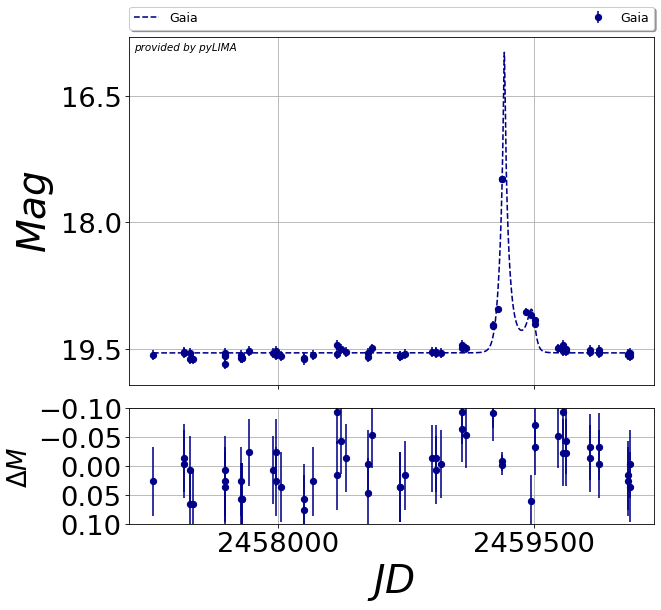

In [5]:
pyLIMA_plots.list_of_fake_telescopes = []#for replotting required, perhaps fixed by now?
pyLIMA_plots.plot_lightcurves(pspl, fit_gaia.fit_results['best_model'])
plt.show()

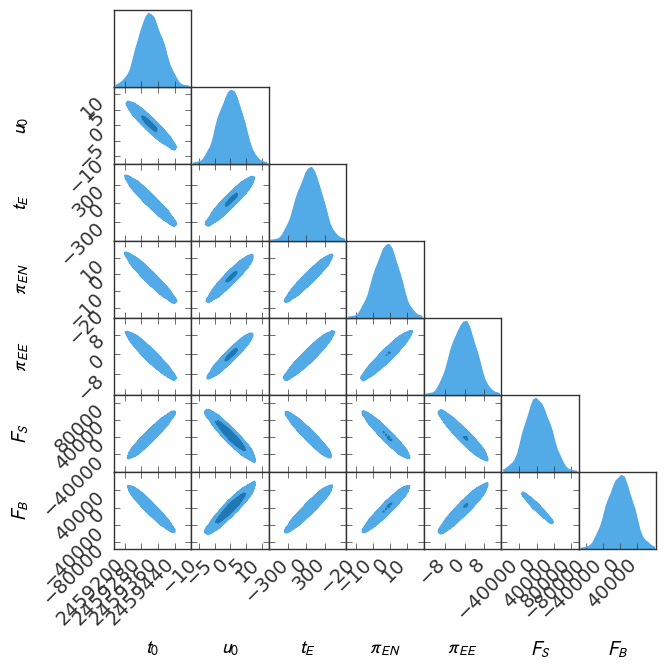

In [6]:
#manual plot, now automatic in v1.9 - skip
cov_fit = fit_gaia.fit_results["covariance_matrix"]
best_fit = fit_gaia.fit_results["best_model"]
mean_for_sampling = fit_gaia.fit_results["best_model"]
cov_for_sampling = cov_fit
n_samples_plot = 2000
samples = np.random.multivariate_normal(mean_for_sampling, cov_for_sampling, n_samples_plot)


names = ['$t_0$',
         '$u_0$', '$t_{E}$','$\\pi_{EN}$', '$\\pi_{EE}$','$F_S$', '$F_B$']
GTC = pygtc.plotGTC(chains=samples,
                    paramNames=names,
                    figureSize=7,
                    customLabelFont={'family':'DejaVu Sans', 'size':14},
                    customLegendFont={'family':'DejaVu Sans', 'size':14},
                    customTickFont={'family':'DejaVu Sans', 'size':14})
plt.show()

In [7]:
import multiprocessing as mul
pool = mul.Pool(processes = 2)
fit_gaia = MCMC_fit.MCMCfit(pspl)    
fit_gaia.model_parameters_guess = [t0guess,u0guess,22,0.1,0.1]
fit_gaia.fit_parameters["tE"][1] = [3.,3000.]
fit_gaia.fit_parameters["u0"][1] = [-2.,2.]
fit_gaia.fit_parameters["piEE"][1] = [-2,2.]
fit_gaia.fit_parameters["piEN"][1] = [-2,2.]
#fit_gaia.model_parameters_guess = [2458528.3504404784,0.09458780564022873,498.98349820381503,-0.19478159344772683,0.08762190327459218]
#delta_t0,delta_u0=1,1
#fit_gaia.fit_parameters["t0"][1]=[t0guess-delta_t0,t0guess+delta_t0]
#fit_gaia.fit_parameters["u0"][1]=[u0guess-delta_u0,u0guess+delta_u0]
#etc.
fit_gaia.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459311.1339800586, 0.30024013729431515, 22.0, 0.1, 0.1]


100%|███████████████████████████████████████| 5000/5000 [00:59<00:00, 84.54it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [ 2.45931624e+06  4.75072975e-03  4.97315628e+02 -2.09548274e-01
 -4.36277362e-02  7.87565786e+01  1.29729409e+03] ln(likelihood) -348.3478121624676


In [8]:
samples_without_ln_like = fit_gaia.fit_results["MCMC_chains"][:,:,:5]

In [13]:
print(fit_gaia.fit_results['MCMC_chains'])
print(fit_gaia.fit_results['MCMC_chains'].shape)

[[[ 2.45931115e+06  3.28583819e-01  2.20063550e+01  1.09900104e-01
    1.06662445e-01 -4.71048740e+02]
  [ 2.45931113e+06  3.05834330e-01  2.20059532e+01  9.00369327e-02
    9.45796518e-02 -4.72660565e+02]
  [ 2.45931114e+06  2.79164360e-01  2.20069963e+01  1.01264971e-01
    9.13226949e-02 -4.75116752e+02]
  ...
  [ 2.45931112e+06  3.25302049e-01  2.20004561e+01  1.08783147e-01
    9.67388776e-02 -4.71197167e+02]
  [ 2.45931112e+06  3.30339224e-01  2.19984930e+01  8.94406631e-02
    1.03906029e-01 -4.70976833e+02]
  [ 2.45931113e+06  2.83911654e-01  2.20082510e+01  9.24446721e-02
    9.86925377e-02 -4.74679351e+02]]

 [[ 2.45931115e+06  3.28583819e-01  2.20063550e+01  1.09900104e-01
    1.06662445e-01 -4.71048740e+02]
  [ 2.45931113e+06  3.05834330e-01  2.20059532e+01  9.00369327e-02
    9.45796518e-02 -4.72660565e+02]
  [ 2.45931114e+06  2.86093867e-01  2.20072881e+01  1.00354529e-01
    9.24665905e-02 -4.74412857e+02]
  ...
  [ 2.45931112e+06  3.27314225e-01  2.20001831e+01  1.09002

In [14]:
np.shape(fit_gaia.fit_results["MCMC_chains_with_fluxes"])

(5000, 10, 8)

In [15]:
#Run KS test on 2nd parameter...
stats.normal_Kolmogorov_Smirnov(fit_gaia.fit_results["MCMC_chains"][:,:,1].ravel())

(0.5000005953399761, 0.0, 0)

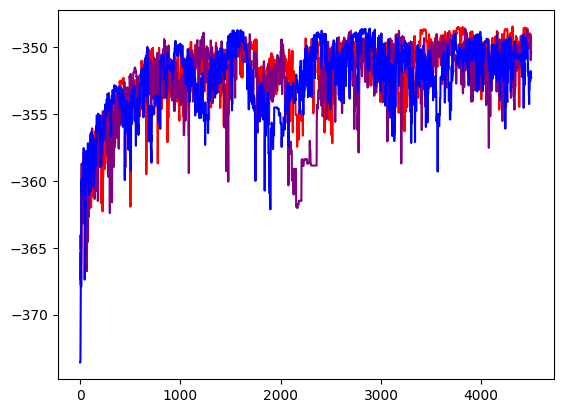

In [16]:
plt.plot(fit_gaia.fit_results["MCMC_chains_with_fluxes"][500:,1,-1],color="red")
plt.plot(fit_gaia.fit_results["MCMC_chains_with_fluxes"][500:,2,-1],color="purple")
plt.plot(fit_gaia.fit_results["MCMC_chains_with_fluxes"][500:,3,-1],color="blue")
#seem to mix well, burn-in after 1500 samples perhaps...

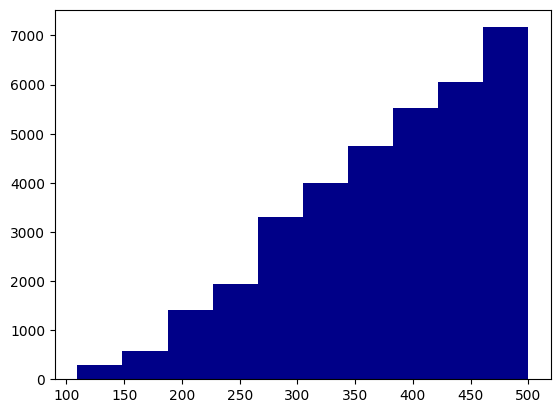

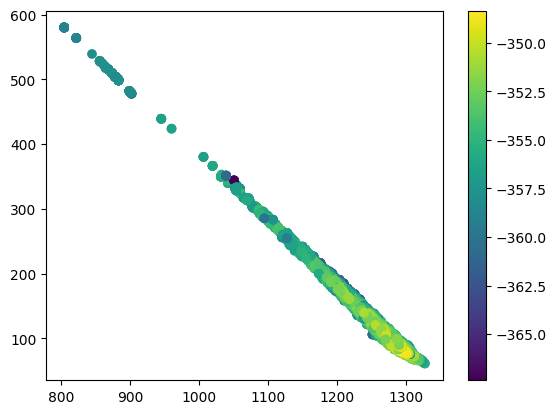

3.155531536857504

In [17]:
#samples with flux FS and FB parameters indicating source and blend flux.
plt.hist(fit_gaia.fit_results["MCMC_chains_with_fluxes"][1500:,:,2].ravel())
#seems to reach limit
plt.show()
plt.scatter(fit_gaia.fit_results["MCMC_chains_with_fluxes"][1500:,:,-2],
            fit_gaia.fit_results["MCMC_chains_with_fluxes"][1500:,:,-3],
            c = fit_gaia.fit_results["MCMC_chains_with_fluxes"][1500:,:,-1])
plt.colorbar()
plt.show()
fit_metrics.Gelman_Rubin(fit_gaia.fit_results["MCMC_chains_with_fluxes"][2500:,:,-2])

In [18]:
fit_metrics.Gelman_Rubin(fit_gaia.fit_results["MCMC_chains_with_fluxes"][:,:,:])#all dimensions scatter within chain and between chains

array([2.21602683, 1.22972055, 3.22115754, 4.27312891, 3.34582939,
       1.189778  , 1.19483322, 0.99770721])

In [19]:
fit_metrics.autocorrelation_time(fit_gaia.fit_results["MCMC_chains_with_fluxes"][:,:,:])

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [215.65237813 232.43740516 592.53071974 456.6284994  114.22123777
 403.51280194 401.96590151 414.29185675]

In [ ]:
fit_gaia.fit_parameters

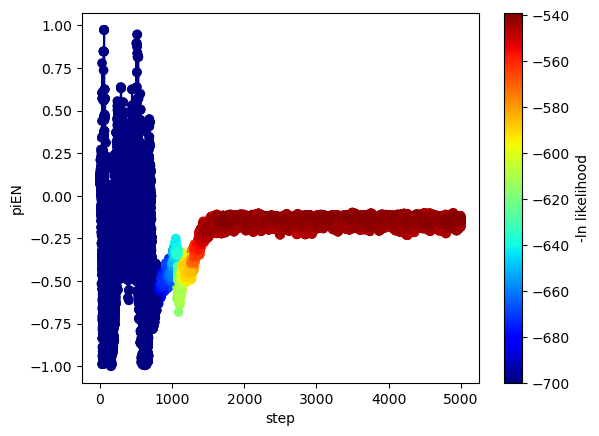

/tmp/ipykernel_24284/2544331301.py:13: RuntimeWarning: invalid value encountered in sqrt
  plt.plot((fit_gaia.fit_results["MCMC_chains"][:,:,3][3000:]**2+fit_gaia.fit_results["MCMC_chains"][:,:,4][3000:]*2)**0.5)


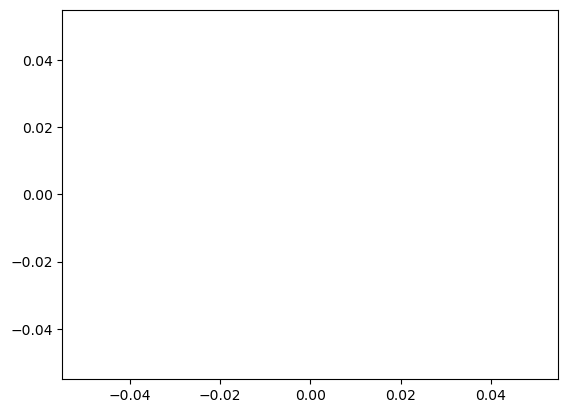

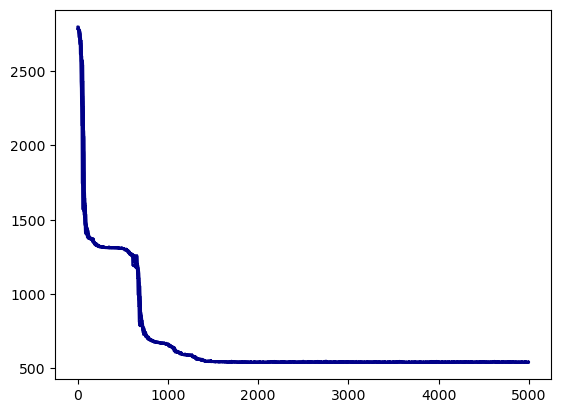

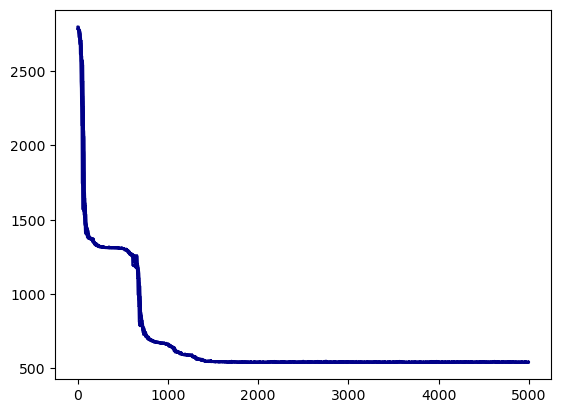

(array([ 24.,  63., 103., 188., 244., 175., 185., 282., 393., 343.]),
 array([325.65094273, 343.0686397 , 360.48633667, 377.90403363,
        395.3217306 , 412.73942757, 430.15712454, 447.57482151,
        464.99251848, 482.41021545, 499.82791242]),
 <BarContainer object of 10 artists>)

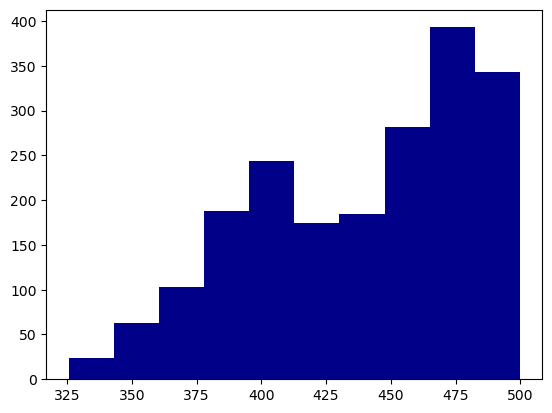

In [47]:
fit_gaia.fit_results["MCMC_chains"].shape
plt.plot(fit_gaia.fit_results["MCMC_chains"][:,:,3])
walkers = len(samples_without_ln_like[0])
for idx in range(walkers):
    plt.scatter(np.arange(len(fit_gaia.fit_results["MCMC_chains"][:,idx,3])),fit_gaia.fit_results["MCMC_chains"][:,idx,3],
            c=fit_gaia.fit_results["MCMC_chains"][:,idx,5], zorder=10,cmap="jet",vmin=-700)
    
cb = plt.colorbar()
cb.set_label("-ln likelihood")
plt.xlabel("step")
plt.ylabel("piEN")
plt.show()
plt.plot((fit_gaia.fit_results["MCMC_chains"][:,:,3][3000:]**2+fit_gaia.fit_results["MCMC_chains"][:,:,4][3000:]*2)**0.5)
plt.show()
plt.plot(-fit_gaia.fit_results["MCMC_chains"][:,:,5])
plt.show()
plt.plot(-fit_gaia.fit_results["MCMC_chains"][:,:,5])
plt.show()
plt.hist(fit_gaia.fit_results["MCMC_chains"][3000:,2,2])

Parallax(Full) estimated for the telescope Gaia: SUCCESS


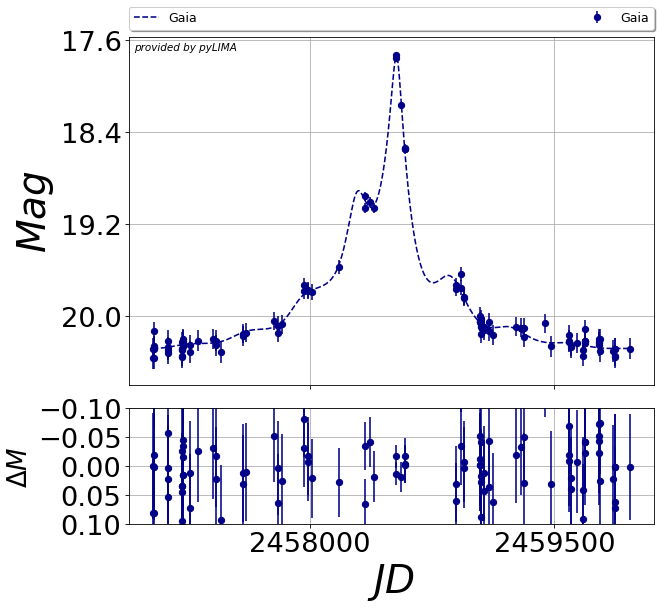

In [48]:
pyLIMA_plots.list_of_fake_telescopes = []#for replotting
pyLIMA_plots.plot_lightcurves(pspl, fit_gaia.fit_results['best_model'])
plt.show()